In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import ParameterGrid

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.ae_torch_classes import *

# Load in Data

In [2]:
# Kai's laptop
#data_path = 
#metadata_cols_df = pd.read_pickle('C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\metadata_cols_df.pkl')
# BRC Desktop
data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\filtered_datasets\\Both_PPD\\"
metadata_cols_df = pd.read_pickle('D:\\Kai_MetaGestureClustering_24\\saved_datasets\\metadata_cols_df.pkl')

print("Loading")

metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']

# Dropping the metadata when we read it in!
training_u_df = pd.read_pickle(data_path+'training_users_df.pkl').drop(metadata_cols, axis=1)
test_users_df = pd.read_pickle(data_path+'test_users_df.pkl').drop(metadata_cols, axis=1)

Loading


In [3]:
print(training_u_df.shape)
training_u_df.head()

(160000, 88)


,IMU1_ax,IMU1_ay,IMU1_az,IMU1_vx,IMU1_vy,IMU1_vz,IMU2_ax,IMU2_ay,IMU2_az,IMU2_vx,...,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,-0.551109,-0.738972,-0.985439,0.181924,0.059616,0.087024,1.055804,-0.883268,-0.327978,-0.221822,...,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,-0.571115,-0.821726,-0.975036,0.242607,0.067375,-0.024900,1.007074,-0.944195,-0.363602,-0.149833,...,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,-0.509305,-0.823575,-0.947221,0.550111,0.013848,-0.485765,0.993332,-0.944029,-0.357476,-0.164447,...,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,-0.511788,-0.775810,-0.947939,0.417919,0.087222,-0.229441,1.026003,-0.911993,-0.335594,-0.006214,...,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,-0.441369,-0.921726,-0.882652,1.254970,0.108993,-0.933639,1.001748,-0.939228,-0.357917,0.009543,...,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [4]:
# CREATE THE TRAINING SET
num_rows_per_gesture = 64 # From the interp
num_gestures = len(training_u_df) // num_rows_per_gesture
num_features = training_u_df.shape[1]

# Ensure the data can be evenly divided into gestures
assert len(training_u_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns)
X_3D_PCA40 = training_u_df.to_numpy().reshape(num_gestures, num_rows_per_gesture, num_features)
#flattened_PCA = PCA_np.reshape(num_gestures, -1)

# Convert to PyTorch tensor
X_3DTensor_PCA40 = torch.tensor(X_3D_PCA40, dtype=torch.float32)

# Dummy dataset
#data = torch.randn(num_gestures, timesteps, num_features)
#dataset = TensorDataset(data)
#data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Create the dataset
u_training_dataset = GestureDatasetAE(X_3DTensor_PCA40)

batch_size = 32  # Adjust batch size as needed
train_loader = DataLoader(u_training_dataset, batch_size=batch_size, shuffle=True) # Should shuffle be False? 
## It's shuffling the gesture order I think so that should be fine...

# CREATE THE TEST SET
num_test_gestures = len(test_users_df) // num_rows_per_gesture
# Ensure the data can be evenly divided into gestures
assert len(test_users_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns) and convert to torch tensor
## Theres probably an easier way to just create it as a torch tensor lol
Xtest_3DTensor_PCA40 = torch.tensor(test_users_df.to_numpy().reshape(num_test_gestures, num_rows_per_gesture, num_features), dtype=torch.float32)

# Create the dataset
u_testing_dataset = GestureDatasetAE(Xtest_3DTensor_PCA40)
test_loader = DataLoader(u_testing_dataset, batch_size=batch_size, shuffle=False)

# RNN Autoencoder

In [7]:
# Example usage
input_dim = 88
#num_features = 40
seq_len = 64
#timesteps = 64
criterion = nn.MSELoss()
num_epochs = 10

## Manual Grid Search

Started
Epoch 0: Train Loss: 0.8225594608089591;  Validation Loss: 0.682925821705298
Epoch 1: Train Loss: 0.605431045158;  Validation Loss: 0.5806816071271896
Epoch 2: Train Loss: 0.5298643357391599;  Validation Loss: 0.5260104509917173
Epoch 3: Train Loss: 0.4730492603929737;  Validation Loss: 0.4700398885390975
Epoch 4: Train Loss: 0.42522170366365697;  Validation Loss: 0.4335884756662629
Epoch 5: Train Loss: 0.38783241751827774;  Validation Loss: 0.4028852412646467
Epoch 6: Train Loss: 0.3648547303827503;  Validation Loss: 0.3865776847709309
Epoch 7: Train Loss: 0.34816730493986153;  Validation Loss: 0.374756168235432
Epoch 8: Train Loss: 0.3387365073342867;  Validation Loss: 0.3693587454882535
Epoch 9: Train Loss: 0.33032834982570214;  Validation Loss: 0.3598154282028025


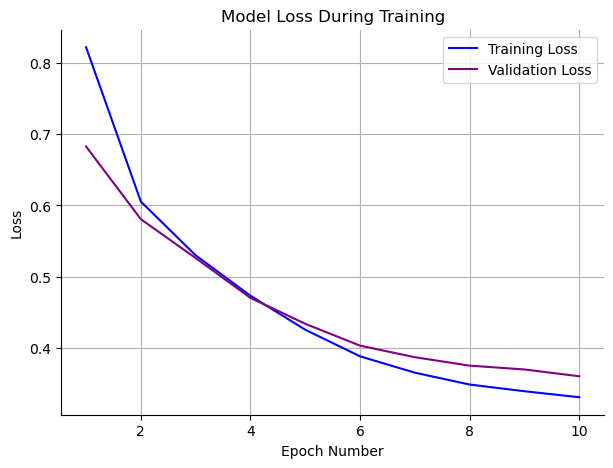

In [8]:
print("Started")

# Hyperparameters and dataset setup
num_layers = 3
lr = 0.001
hidden_dim = 56

# With progressive halving
model_56_nl3_prog, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim, num_layers, train_loader, test_loader, progressive_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.845959670936005;  Validation Loss: 0.7082490189508959
Epoch 1: Train Loss: 0.6715805191027967;  Validation Loss: 0.6210897253318266
Epoch 2: Train Loss: 0.5899358406851564;  Validation Loss: 0.5596963614225388
Epoch 3: Train Loss: 0.5245003066485441;  Validation Loss: 0.5014508732340552
Epoch 4: Train Loss: 0.46672249632545665;  Validation Loss: 0.4652398154139519
Epoch 5: Train Loss: 0.43882917339288735;  Validation Loss: 0.4496906420046633
Epoch 6: Train Loss: 0.42289311900923526;  Validation Loss: 0.4425987716425549
Epoch 7: Train Loss: 0.4109586360333841;  Validation Loss: 0.4394963045011867
Epoch 8: Train Loss: 0.4043410993829558;  Validation Loss: 0.4321730739691041
Epoch 9: Train Loss: 0.3956937623929374;  Validation Loss: 0.42599265480583365


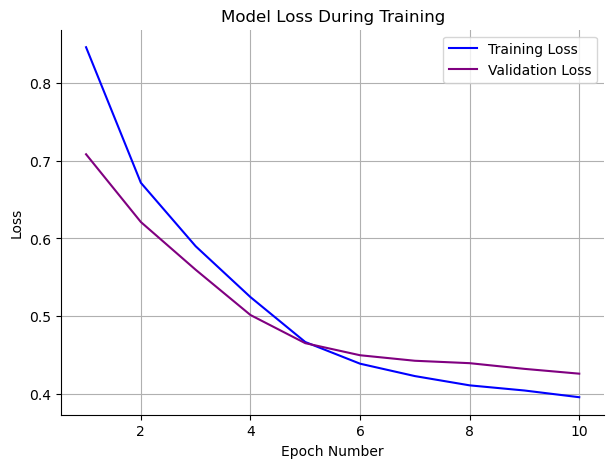

In [10]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001
hidden_dim_list = [56, 28, 14]

# With mirroring
model_56_28_14mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.9355146402045141;  Validation Loss: 0.8389051502401178
Epoch 1: Train Loss: 0.8197152425971213;  Validation Loss: 0.7761367342688821
Epoch 2: Train Loss: 0.7985861950282809;  Validation Loss: 0.7638790553266351
Epoch 3: Train Loss: 0.7914024568811248;  Validation Loss: 0.7620372501286593
Epoch 4: Train Loss: 0.7848687436007247;  Validation Loss: 0.7601929388263009
Epoch 5: Train Loss: 0.7783421323269228;  Validation Loss: 0.7537892609834671
Epoch 6: Train Loss: 0.7636701079863536;  Validation Loss: 0.7455905662341551
Epoch 7: Train Loss: 0.7444172954257531;  Validation Loss: 0.7323623286052183
Epoch 8: Train Loss: 0.7175796899614455;  Validation Loss: 0.7170813043009151
Epoch 9: Train Loss: 0.6959976659545416;  Validation Loss: 0.705958679318428


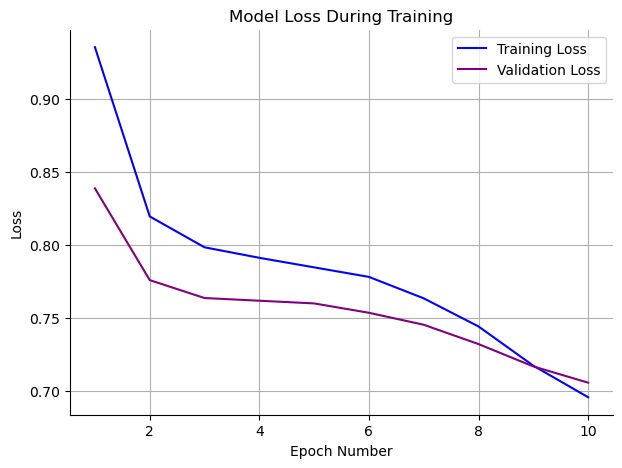

In [11]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [42, 32, 16, 8, 3]
model_42_32_16_8_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.917205940319013;  Validation Loss: 0.8058303161100908
Epoch 1: Train Loss: 0.8078202001656158;  Validation Loss: 0.7683999362316999
Epoch 2: Train Loss: 0.7767282098154479;  Validation Loss: 0.7319860553199594
Epoch 3: Train Loss: 0.7187009499042849;  Validation Loss: 0.7032713239843195
Epoch 4: Train Loss: 0.6951166557360299;  Validation Loss: 0.6859156800941988
Epoch 5: Train Loss: 0.6793586181688912;  Validation Loss: 0.6778950040990656
Epoch 6: Train Loss: 0.6664508136012887;  Validation Loss: 0.6663810786875811
Epoch 7: Train Loss: 0.6520198417615287;  Validation Loss: 0.666449098424478
Epoch 8: Train Loss: 0.6437612930430642;  Validation Loss: 0.6676424105059017
Epoch 9: Train Loss: 0.6373785198489322;  Validation Loss: 0.6656637760725889


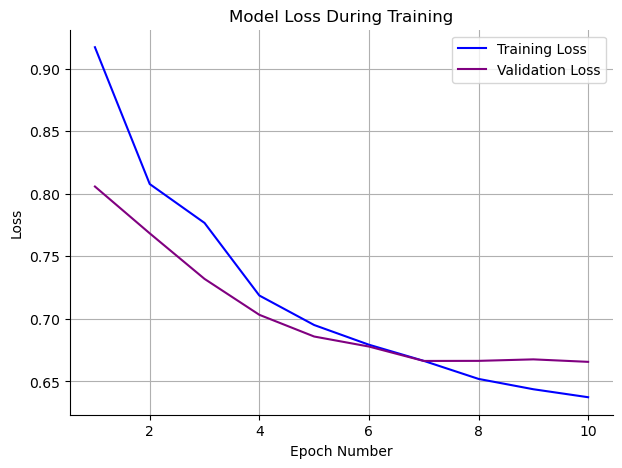

In [12]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [100, 32, 16, 8, 3]
model_100_32_16_8_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.8984950705419613;  Validation Loss: 0.786957011981444
Epoch 1: Train Loss: 0.7731732711007323;  Validation Loss: 0.7349907661026175
Epoch 2: Train Loss: 0.7288804506953759;  Validation Loss: 0.7064287215471268
Epoch 3: Train Loss: 0.7153455177439919;  Validation Loss: 0.6886813166466627
Epoch 4: Train Loss: 0.7002094750162922;  Validation Loss: 0.6742189919406717
Epoch 5: Train Loss: 0.6877459483810618;  Validation Loss: 0.6702246137640693
Epoch 6: Train Loss: 0.6757219245162192;  Validation Loss: 0.6721030947836962
Epoch 7: Train Loss: 0.6660303775268265;  Validation Loss: 0.6700179441408678
Epoch 8: Train Loss: 0.6559595126139967;  Validation Loss: 0.6641665480353616
Epoch 9: Train Loss: 0.6477391357663311;  Validation Loss: 0.6629579961299896


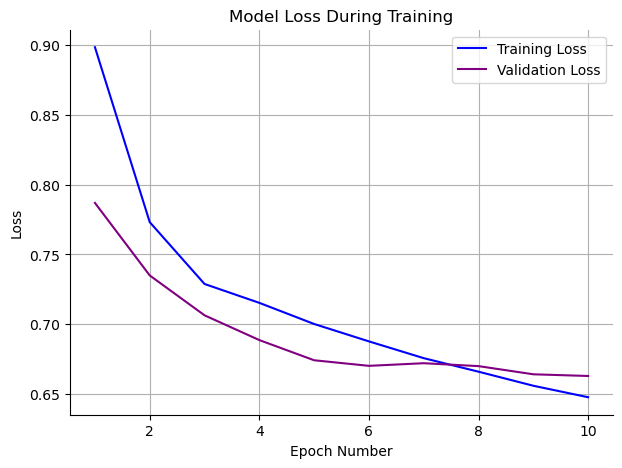

In [13]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [56, 28, 3]
model_56_28_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.6773400253887418;  Validation Loss: 0.47700774940577423
Epoch 1: Train Loss: 0.36877215172671063;  Validation Loss: 0.3210706575350328
Epoch 2: Train Loss: 0.25221690818478787;  Validation Loss: 0.24138349226929925
Epoch 3: Train Loss: 0.18808971024766752;  Validation Loss: 0.19557507065209476
Epoch 4: Train Loss: 0.1507861054019083;  Validation Loss: 0.16660240428014236
Epoch 5: Train Loss: 0.1268850919566577;  Validation Loss: 0.14744058945639568
Epoch 6: Train Loss: 0.11081074583756773;  Validation Loss: 0.1317014301365072
Epoch 7: Train Loss: 0.09783800342414953;  Validation Loss: 0.11915323832495646
Epoch 8: Train Loss: 0.08751820565401754;  Validation Loss: 0.10902821204879067
Epoch 9: Train Loss: 0.07976882070114341;  Validation Loss: 0.1010797501287677


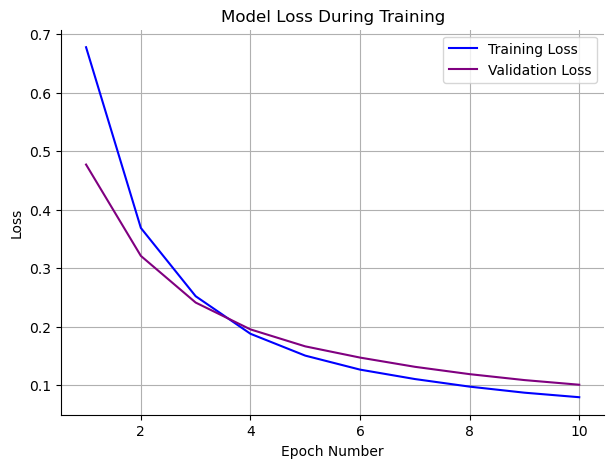

In [14]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [64]
model_64mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.75666270150414;  Validation Loss: 0.5812752693891525
Epoch 1: Train Loss: 0.47666364304627046;  Validation Loss: 0.42798406088894064
Epoch 2: Train Loss: 0.3680756473088566;  Validation Loss: 0.3619647425684062
Epoch 3: Train Loss: 0.3060958726873881;  Validation Loss: 0.3085652904754335
Epoch 4: Train Loss: 0.2610470156503629;  Validation Loss: 0.27207635275342246
Epoch 5: Train Loss: 0.23169677261310287;  Validation Loss: 0.24620089341293683
Epoch 6: Train Loss: 0.21072445885290073;  Validation Loss: 0.22713214057413014
Epoch 7: Train Loss: 0.19332182030134562;  Validation Loss: 0.21283173357898538
Epoch 8: Train Loss: 0.17839347825774662;  Validation Loss: 0.19989403354173357
Epoch 9: Train Loss: 0.16685031693947466;  Validation Loss: 0.18876454640518536


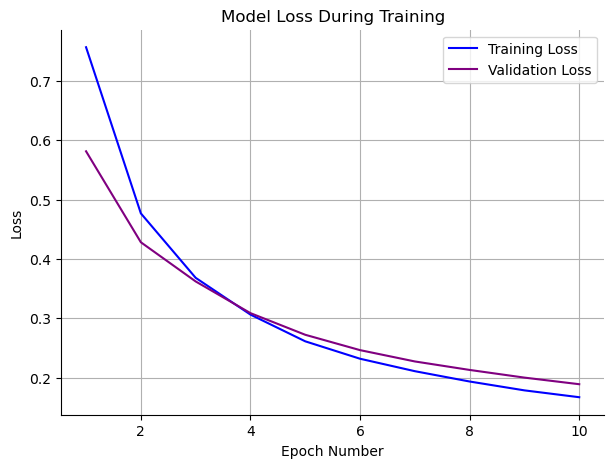

In [15]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [64, 40]
model_64_40, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.7986981589582902;  Validation Loss: 0.6605074459856207
Epoch 1: Train Loss: 0.5821780781202679;  Validation Loss: 0.5356129164045508
Epoch 2: Train Loss: 0.47495451418659357;  Validation Loss: 0.4595213667912917
Epoch 3: Train Loss: 0.41484705896317203;  Validation Loss: 0.41867410188371484
Epoch 4: Train Loss: 0.3745432171640517;  Validation Loss: 0.3866820701143958
Epoch 5: Train Loss: 0.3454749320126787;  Validation Loss: 0.3674659878015518
Epoch 6: Train Loss: 0.32504955122742474;  Validation Loss: 0.3486059700900858
Epoch 7: Train Loss: 0.30630425241174575;  Validation Loss: 0.33481011201034894
Epoch 8: Train Loss: 0.29228630586515497;  Validation Loss: 0.32563138143582776
Epoch 9: Train Loss: 0.2787164998582647;  Validation Loss: 0.3058515573767098


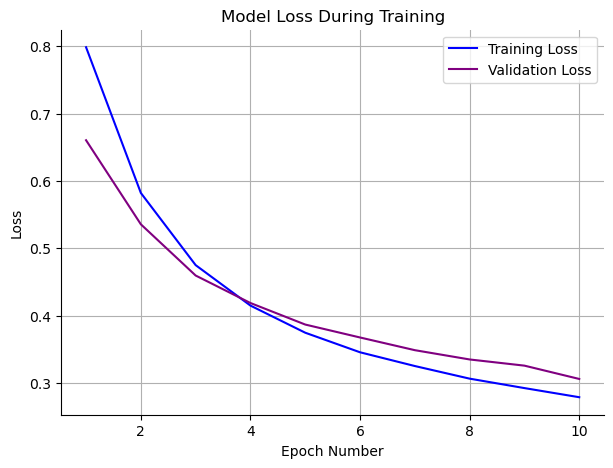

In [16]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [64, 40, 32]
model_64_40_32mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.8291720996929121;  Validation Loss: 0.6907518384131518
Epoch 1: Train Loss: 0.6150743029540098;  Validation Loss: 0.5587698018009012
Epoch 2: Train Loss: 0.5038584772544571;  Validation Loss: 0.4747121591459621
Epoch 3: Train Loss: 0.4311250512358509;  Validation Loss: 0.422422701662237
Epoch 4: Train Loss: 0.381528128928776;  Validation Loss: 0.39061403003605927
Epoch 5: Train Loss: 0.35073935985565186;  Validation Loss: 0.36550708589228714
Epoch 6: Train Loss: 0.32867907572396193;  Validation Loss: 0.343639654869383
Epoch 7: Train Loss: 0.30729796388481234;  Validation Loss: 0.32422744211825455
Epoch 8: Train Loss: 0.28948450163949896;  Validation Loss: 0.3083874149755998
Epoch 9: Train Loss: 0.2754514736088016;  Validation Loss: 0.2962405603717674


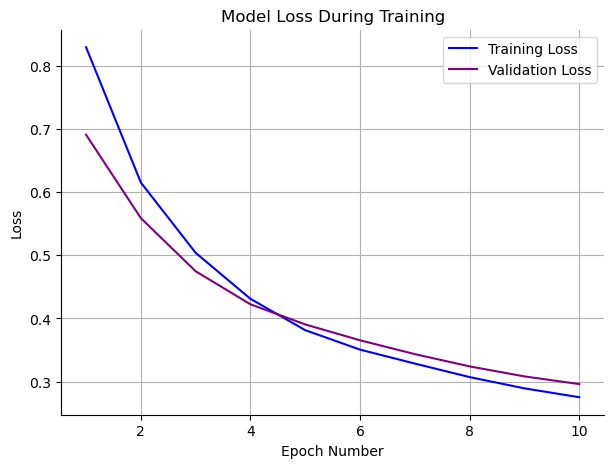

In [17]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [44, 22]
model_44_22mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.7945438208459299;  Validation Loss: 0.6310143782333895
Epoch 1: Train Loss: 0.5533080832867683;  Validation Loss: 0.49803834747184406
Epoch 2: Train Loss: 0.4458116243911695;  Validation Loss: 0.42435611987655814
Epoch 3: Train Loss: 0.3798431527765491;  Validation Loss: 0.38690267435529013
Epoch 4: Train Loss: 0.3478604091119163;  Validation Loss: 0.3595177538015626
Epoch 5: Train Loss: 0.31720683054078985;  Validation Loss: 0.33126385645432904
Epoch 6: Train Loss: 0.29285244304168073;  Validation Loss: 0.30659177763895556
Epoch 7: Train Loss: 0.2731270614681365;  Validation Loss: 0.28933863985267555
Epoch 8: Train Loss: 0.25747256395937523;  Validation Loss: 0.27694985846226866
Epoch 9: Train Loss: 0.24752427882786038;  Validation Loss: 0.26212913915514946


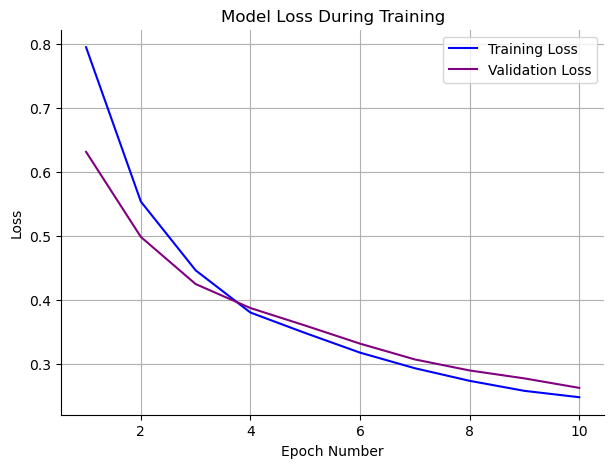

In [18]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [64, 22]
model_64_22mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.7674694129183323;  Validation Loss: 0.6298358183015477
Epoch 1: Train Loss: 0.5455985325801221;  Validation Loss: 0.49745956605130975
Epoch 2: Train Loss: 0.43043235849730577;  Validation Loss: 0.4272818125107072
Epoch 3: Train Loss: 0.3793283214297476;  Validation Loss: 0.395739345387979
Epoch 4: Train Loss: 0.3526226316071764;  Validation Loss: 0.37216336686502804
Epoch 5: Train Loss: 0.33154056494749046;  Validation Loss: 0.3525169159878384
Epoch 6: Train Loss: 0.31668211123611356;  Validation Loss: 0.33798036859794095
Epoch 7: Train Loss: 0.30761400959159757;  Validation Loss: 0.3281306407668374
Epoch 8: Train Loss: 0.29767993450919283;  Validation Loss: 0.3221439177339727
Epoch 9: Train Loss: 0.2881574272354947;  Validation Loss: 0.31089180741797795


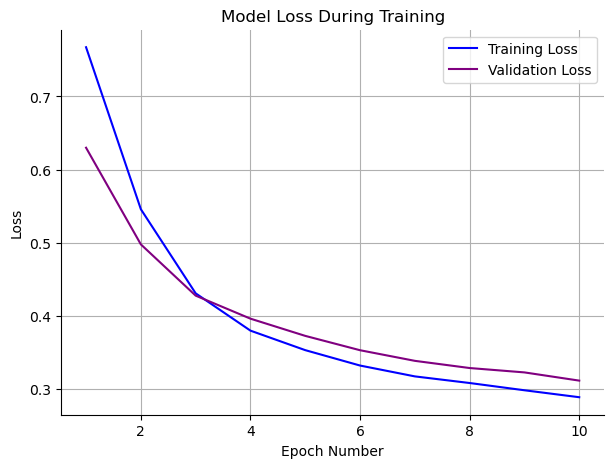

In [19]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [96, 48, 22]
model_96_48_22mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

In [ ]:
assert(False)

Save a few of the above models

In [20]:
torch.save(model_56_28_3mir .state_dict(), 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\Embedding\\Autoencoders\\RNNAE_56_28_3mir_vallossp662_BothFull.pth')
torch.save(model_64_22mir.state_dict(), 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\Embedding\\Autoencoders\\RNNAE_64_22mir_vallossp262_BothFull.pth')
